In [6]:
import pandas
import numpy as np
from utils import *
import mne
import matplotlib.pyplot as plt
from os import walk
from tqdm.notebook import tqdm

from sklearn.naive_bayes import GaussianNB
from itertools import combinations
from mne.time_frequency import tfr_morlet

plt.style.use('seaborn-whitegrid')

In [ ]:
df = pandas.read_csv('./HEXACO.csv')
# Honesty-Humility	Emotionality	eXtraversion	Agreeableness	Conscientiousness	Openness to Experience
gt = df[['id','Honesty-Humility','Emotionality','eXtraversion','Agreeableness','Conscientiousness','Openness to Experience']].rename(columns={'Honesty-Humility':'h',
                                  'Emotionality':'e',
                                  'eXtraversion':'x',
                                 'Agreeableness':'a',
                             'Conscientiousness':'c',
                        'Openness to Experience':'o'}).set_index('id')
thold = 3.5
gt['lh'] = (gt[['h']] > thold) * 1
gt['le'] = (gt[['e']] > thold) * 1
gt['lx'] = (gt[['x']] > thold) * 1
gt['la'] = (gt[['a']] > thold) * 1
gt['lc'] = (gt[['c']] > thold) * 1
gt['lo'] = (gt[['o']] > thold) * 1

In [2]:
path, folders, filenames = next(walk('./data'))
# Exclude these data because of incomplete data
gt.drop([11,4,36],inplace=True)

filenames.remove('11-audio.csv')
filenames.remove('11-image.csv')

filenames.remove('36-audio.csv')
filenames.remove('36-image.csv')

In [3]:
path = './data'
columns = {'Unnamed: 1':'Fp1',
        'Unnamed: 2':'Fp2',
        'Unnamed: 3':'F3',
        'Unnamed: 4':'F4',
        'Unnamed: 5':'F7',
        'Unnamed: 6':'F8',
        'Unnamed: 7':'P7',
        'Unnamed: 8':'P8'}

EEG_audio, EEG_image = dict(), dict()
from itertools import product
categories = [1,2,3,4,5]
blocks = [1,2]
for filename in tqdm(filenames):
    participant_id, stimuli = filename.split('-')
    stimuli = stimuli.rstrip('.csv')
    data = pandas.read_csv(f'{path}/{filename}', dtype={'Marker': str}).rename(columns=columns).drop(columns='timestamps')
    # print(participant_id, stimuli)
    # experiment = dict()
    # for (category, block) in product(categories,blocks):
        # print("   ", category, block)
        # section = get_section_from_catblock(data, category=category,block=block)
        # experiment[f"{category}_{block}"] = section
    if(stimuli == 'audio'):
        EEG_audio[int(participant_id)] = data
    elif(stimuli == 'image'):
        EEG_image[int(participant_id)] = data
    else:
        raise ValueError(f"Stimuli:{stimuli} is unexpected.")

In [6]:
# Preprocess data + feature extraction using wavelet 'morlet'
def get_data_wt(eeg_type = 'image'):
    X = None
    # y = []
    Y = None
    participant_id = []
    categories = []
    # 'DELTA' 'THETA' 'ALPHA' 'BETA' 'Gamma'
    # https://reader.elsevier.com/reader/sd/pii/S0957417410005695?token=99F7CC487CECF9C17E36713347D0F8372A289AC2C6331A2B6C4F272CD34921FD8B418EB417C0F9C3796CEA271FB4455D&originRegion=eu-west-1&originCreation=20210510142445
    filter_list = np.array([4,8,13,30,125])
    # ids = [33,2,10,12,16]
    ids = gt.index.tolist()
    for id in tqdm(ids):
        # print('\n',"="*20,id)
        if(eeg_type == 'image'):
            raw = dataframe_to_raw(EEG_image[id], sfreq=250)
        else:
            raw = dataframe_to_raw(EEG_audio[id], sfreq=250)

        raw.notch_filter([50,100],filter_length='auto', phase='zero', verbose=False) # Line power
        raw.filter(1., None, fir_design='firwin', verbose=False) # Slow drift

        events = mne.find_events(raw, stim_channel='Marker', initial_event=True, verbose=False)
        events = np.delete(events,np.argwhere(events[:,2] == 1), axis=0)
        if(events.shape[0] != 50):
            raise ValueError(f"Event missing: {events[:,2]}. len(events.shape[0])={events.shape[0]}")
        epochs = mne.Epochs(raw, events, tmin=0, tmax=5.8, baseline=(0.3,0.3), verbose=False)
        if(epochs.get_data().shape[0] != 50):
            raise ValueError(f"There might be a bad data. epochs.get_data().shape = {epochs.get_data().shape}")

        powers = tfr_morlet(epochs, freqs=filter_list, n_cycles=filter_list / 2., return_itc=False, average=False, verbose=False)
        # features = np.mean(powers.data, axis=3)
        features = powers.data
        # print(features.shape) #(50,8,5,)
        for e in range(features.shape[0]):
            row = np.expand_dims(features[e], axis=0)
            row = 10 * np.log10(row)
            if(type(X) == type(None)): X = row
            else: X = np.concatenate( [X, row ], axis=0 )
            # y.append(gt.loc[id]['label'])

            label = gt.loc[id][['lh','le','lx','la','lc','lo']].to_numpy()
            label = np.expand_dims(label, axis=0)
            if(type(Y) == type(None)): Y = label
            else: Y = np.concatenate( [Y, label ], axis=0 )
            participant_id.append(id)
        for e in events[:,2]:
            categories.append(str(e)[0])
#         print(X.shape)
            # print(Y.shape)
    # y = np.array(y)
    return X,Y,np.array(participant_id),np.array(categories)

In [5]:
import warnings
warnings.filterwarnings("ignore")

channels = list(columns.values())
band_name = np.array(['DELTA','THETA','ALPHA','BETA','Gamma'])
X_head = dict()
count = 0
for channel in channels:
    for band in band_name:
        X_head[count] = (f"{channel}-{band}")
        count += 1
print(X_head)

{0: 'Fp1-DELTA', 1: 'Fp1-THETA', 2: 'Fp1-ALPHA', 3: 'Fp1-BETA', 4: 'Fp1-Gamma', 5: 'Fp2-DELTA', 6: 'Fp2-THETA', 7: 'Fp2-ALPHA', 8: 'Fp2-BETA', 9: 'Fp2-Gamma', 10: 'F3-DELTA', 11: 'F3-THETA', 12: 'F3-ALPHA', 13: 'F3-BETA', 14: 'F3-Gamma', 15: 'F4-DELTA', 16: 'F4-THETA', 17: 'F4-ALPHA', 18: 'F4-BETA', 19: 'F4-Gamma', 20: 'F7-DELTA', 21: 'F7-THETA', 22: 'F7-ALPHA', 23: 'F7-BETA', 24: 'F7-Gamma', 25: 'F8-DELTA', 26: 'F8-THETA', 27: 'F8-ALPHA', 28: 'F8-BETA', 29: 'F8-Gamma', 30: 'P7-DELTA', 31: 'P7-THETA', 32: 'P7-ALPHA', 33: 'P7-BETA', 34: 'P7-Gamma', 35: 'P8-DELTA', 36: 'P8-THETA', 37: 'P8-ALPHA', 38: 'P8-BETA', 39: 'P8-Gamma'}


In [7]:
import pickle
for eeg_type in ['image','audio']:
    X,Y,participant_id,categories = get_data_wt(eeg_type)
    data = {"Y":Y, "part_id":participant_id, "cat":categories}
    print(X.shape,Y.shape,participant_id.shape,categories.shape)
    with open(f'data_extract_raw/{eeg_type}_X.pickle', 'wb') as handle:
        pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(f'data_extract_raw/{eeg_type}_data.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)


(1500, 8, 5, 1451) (1500, 6) (1500,) (1500,)



(1500, 8, 5, 1451) (1500, 6) (1500,) (1500,)


## Load from pickle

In [1]:
import pickle
from tqdm.notebook import tqdm
import numpy as np
from sklearn.naive_bayes import MultinomialNB as model
from sklearn.model_selection import cross_val_score
sampleRate = 250
times = [.1,.2,.3,.4,.5,.6,.7,.8,.9,1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2,3,4,5,5.5,5.8]
# times = [.5,1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5]

In [6]:
# times = np.arange(2,252,2)

In [7]:
# with open(f'data_extract_raw/image_X.pickle', "rb") as handle:
#     X = pickle.load(handle)
# with open(f'data_extract_raw/image_data.pickle', "rb") as handle:
#     data = pickle.load(handle)
# Y = data['Y']

In [2]:
def plot(times,infor,title,ylabel):
    fig, ax = plt.subplots(figsize=(16,9))
    ax.plot(times,np.array(infor['label_h'])*100)
    ax.plot(times,np.array(infor['label_e'])*100)
    ax.plot(times,np.array(infor['label_x'])*100)
    ax.plot(times,np.array(infor['label_a'])*100)
    ax.plot(times,np.array(infor['label_c'])*100)
    ax.plot(times,np.array(infor['label_o'])*100)

    ax.scatter(times,np.array(infor['label_h'])*100, label='H')
    ax.scatter(times,np.array(infor['label_e'])*100, label='E')
    ax.scatter(times,np.array(infor['label_x'])*100, label='X')
    ax.scatter(times,np.array(infor['label_a'])*100, label='A')
    ax.scatter(times,np.array(infor['label_c'])*100, label='C')
    ax.scatter(times,np.array(infor['label_o'])*100, label='O')

    ax.legend()
    ax.set_title(title)
    ax.set_xlabel('time (s)')
    ax.set_ylabel(ylabel)
    plt.show()

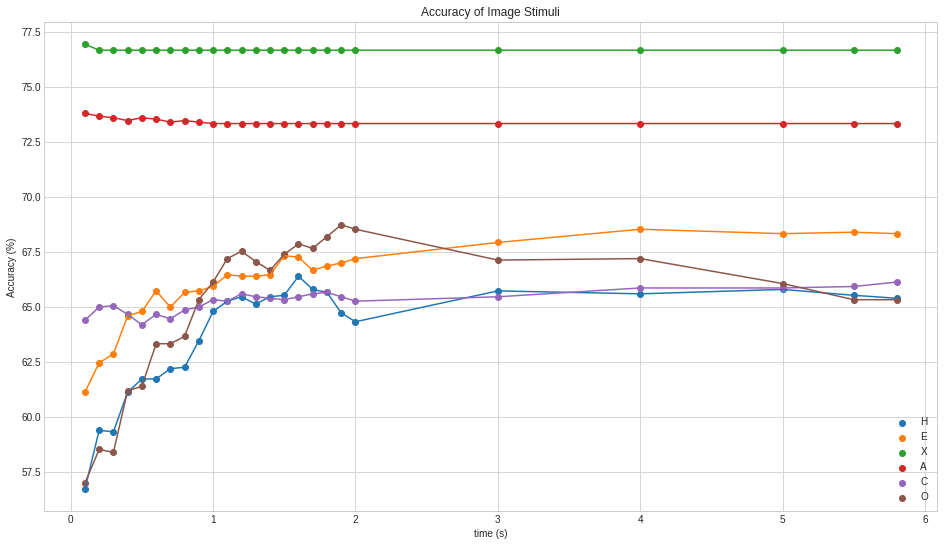

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
time,0.100000,0.200000,0.300000,0.400000,0.500000,0.600000,0.700000,0.800000,0.900000,1.000000,...,1.600000,1.700000,1.800000,1.900000,2.000000,3.000000,4.000000,5.000000,5.500000,5.800000
acc_label_h,0.567333,0.594000,0.593333,0.611333,0.617333,0.617333,0.622000,0.622667,0.634667,0.648000,...,0.664000,0.658000,0.656667,0.647333,0.643333,0.657333,0.656000,0.658000,0.655333,0.654000
acc_label_e,0.611333,0.624667,0.628667,0.646000,0.648000,0.657333,0.650000,0.656667,0.657333,0.659333,...,0.672667,0.666667,0.668667,0.670000,0.672000,0.679333,0.685333,0.683333,0.684000,0.683333
acc_label_x,0.769333,0.766667,0.766667,0.766667,0.766667,0.766667,0.766667,0.766667,0.766667,0.766667,...,0.766667,0.766667,0.766667,0.766667,0.766667,0.766667,0.766667,0.766667,0.766667,0.766667
acc_label_a,0.738000,0.736667,0.736000,0.734667,0.736000,0.735333,0.734000,0.734667,0.734000,0.733333,...,0.733333,0.733333,0.733333,0.733333,0.733333,0.733333,0.733333,0.733333,0.733333,0.733333
acc_label_c,0.644000,0.650000,0.650667,0.646667,0.642000,0.646667,0.644667,0.648667,0.650000,0.653333,...,0.654667,0.656000,0.656667,0.654667,0.652667,0.654667,0.658667,0.658667,0.659333,0.661333
acc_label_o,0.570000,0.585333,0.584000,0.612000,0.614000,0.633333,0.633333,0.636667,0.653333,0.661333,...,0.678667,0.676667,0.682000,0.687333,0.685333,0.671333,0.672000,0.660667,0.653333,0.653333


In [7]:
with open(f'data_extract_raw/image_X.pickle', "rb") as handle:
    X = pickle.load(handle)
with open(f'data_extract_raw/image_data.pickle', "rb") as handle:
    data = pickle.load(handle)
Y = data['Y']
acc_time_image = dict()
score_time_image = dict()
for t in tqdm(times):
#     print("="*20, t ,"="*20)
    for index,label in enumerate(['label_h','label_e','label_x','label_a','label_c','label_o']):
        # X_copy = X.copy()[:,:,:,int(sampleRate*t)-int(sampleRate*.5):int(sampleRate*t)]
        X_copy = X.copy()[:,:,:,:int(t*sampleRate)]
        # print(X_copy.shape)
        X_copy = np.mean(X_copy, axis=3)
        win = None
        for s in range(X_copy.shape[0]):
            row = np.expand_dims(X_copy[s].reshape(-1), axis=0)
            if(type(win) == type(None)): win = row
            else: win = np.concatenate([win,row], axis=0)
        win = win*-1
        y = Y[:,index]
        # print(win.shape, y.shape)
        clf = model()
        clf.fit(win, y)
        acc = sum(clf.predict(win) == y) / len(y)
        scores = cross_val_score(clf, win, y)
        # image_predictor[label] = clf
#         print(label,"| Accuracy: %0.2f Scores: %0.2f (+/- %0.2f)" % (acc,scores.mean(), scores.std() * 2))
        if(label not in acc_time_image.keys()):
            acc_time_image[label] = list()
        if(label not in score_time_image.keys()):
            score_time_image[label] = list()
        acc_time_image[label].append(acc)
        score_time_image[label].append(scores.mean())
plot(times,acc_time_image,title='Accuracy of Image Stimuli',ylabel='Accuracy (%)')
df = pd.DataFrame()
df['time'] = times
for k in acc_time_image.keys():
    df[f"acc_{k}"] = acc_time_image[k]
df.set_index('time')
df.T.to_csv('data_extract_raw/image_acc.csv')
df.T

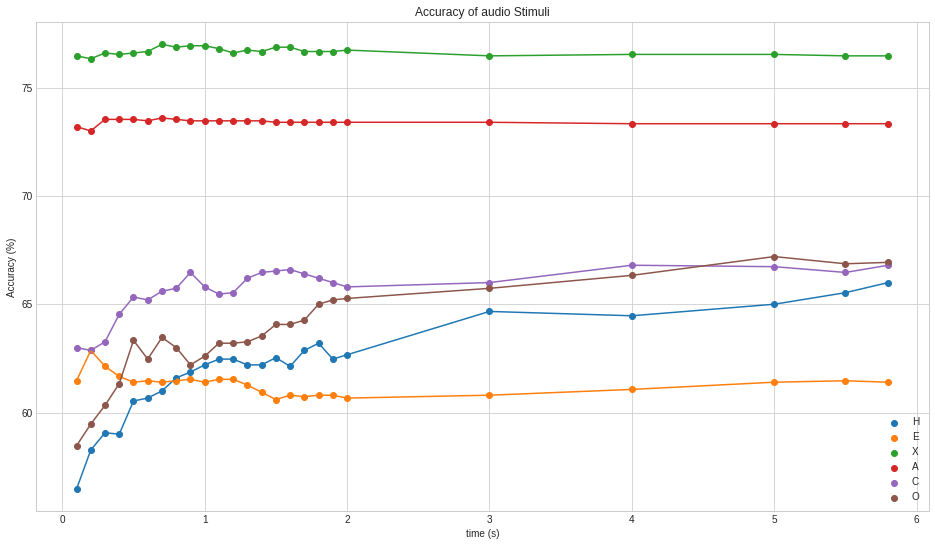

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
time,0.100000,0.200000,0.300000,0.400000,0.500000,0.600000,0.700000,0.800000,0.900000,1.000000,...,1.600000,1.700000,1.800000,1.900000,2.000000,3.000000,4.000000,5.000000,5.500000,5.800000
acc_label_h,0.564667,0.582667,0.590667,0.590000,0.605333,0.606667,0.610000,0.616000,0.618667,0.622000,...,0.621333,0.628667,0.632000,0.624667,0.626667,0.646667,0.644667,0.650000,0.655333,0.660000
acc_label_e,0.614667,0.628667,0.621333,0.616667,0.614000,0.614667,0.614000,0.614667,0.615333,0.614000,...,0.608000,0.607333,0.608000,0.608000,0.606667,0.608000,0.610667,0.614000,0.614667,0.614000
acc_label_x,0.764667,0.763333,0.766000,0.765333,0.766000,0.766667,0.770000,0.768667,0.769333,0.769333,...,0.768667,0.766667,0.766667,0.766667,0.767333,0.764667,0.765333,0.765333,0.764667,0.764667
acc_label_a,0.732000,0.730000,0.735333,0.735333,0.735333,0.734667,0.736000,0.735333,0.734667,0.734667,...,0.734000,0.734000,0.734000,0.734000,0.734000,0.734000,0.733333,0.733333,0.733333,0.733333
acc_label_c,0.630000,0.628667,0.632667,0.645333,0.653333,0.652000,0.656000,0.657333,0.664667,0.658000,...,0.666000,0.664000,0.662000,0.660000,0.658000,0.660000,0.668000,0.667333,0.664667,0.668000
acc_label_o,0.584667,0.594667,0.603333,0.613333,0.633333,0.624667,0.634667,0.630000,0.622000,0.626000,...,0.640667,0.642667,0.650000,0.652000,0.652667,0.657333,0.663333,0.672000,0.668667,0.669333


In [8]:
with open(f'data_extract_raw/audio_X.pickle', "rb") as handle:
    X = pickle.load(handle)
with open(f'data_extract_raw/audio_data.pickle', "rb") as handle:
    data = pickle.load(handle)
Y = data['Y']
acc_time_audio = dict()
score_time_audio = dict()
for t in tqdm(times):
#     print("="*20, t ,"="*20)
    for index,label in enumerate(['label_h','label_e','label_x','label_a','label_c','label_o']):
        # X_copy = X.copy()[:,:,:,int(sampleRate*t)-int(sampleRate*.5):int(sampleRate*t)]
        X_copy = X.copy()[:,:,:,:int(t*sampleRate)]
        # print(X_copy.shape)
        X_copy = np.mean(X_copy, axis=3)
        win = None
        for s in range(X_copy.shape[0]):
            row = np.expand_dims(X_copy[s].reshape(-1), axis=0)
            if(type(win) == type(None)): win = row
            else: win = np.concatenate([win,row], axis=0)
        win = win*-1
        y = Y[:,index]
        # print(win.shape, y.shape)
        clf = model()
        clf.fit(win, y)
        acc = sum(clf.predict(win) == y) / len(y)
        scores = cross_val_score(clf, win, y)
        # audio_predictor[label] = clf
#         print(label,"| Accuracy: %0.2f Scores: %0.2f (+/- %0.2f)" % (acc,scores.mean(), scores.std() * 2))
        if(label not in acc_time_audio.keys()):
            acc_time_audio[label] = list()
        if(label not in score_time_audio.keys()):
            score_time_audio[label] = list()
        acc_time_audio[label].append(acc)
        score_time_audio[label].append(scores.mean())
plot(times,acc_time_audio,title='Accuracy of audio Stimuli',ylabel='Accuracy (%)')
df = pd.DataFrame()
df['time'] = times
for k in acc_time_audio.keys():
    df[f"acc_{k}"] = acc_time_audio[k]
df.set_index('time')
df.T.to_csv('data_extract_raw/audio_acc.csv')
df.T

In [74]:
df_image = pd.DataFrame(acc_time_image).T
df_image = df_image.drop('label_x')
df_image = df_image.drop('label_a').T*100
df_audio = pd.DataFrame(acc_time_audio).T
df_audio = df_audio.drop('label_x')
df_audio = df_audio.drop('label_a').T*100

In [75]:
# df_audio

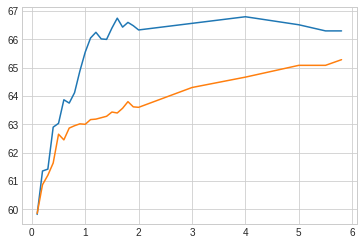

In [76]:
plt.plot(times,np.mean(df_image,axis=1))
plt.plot(times,np.mean(df_audio,axis=1))


In [77]:
[1]*20

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

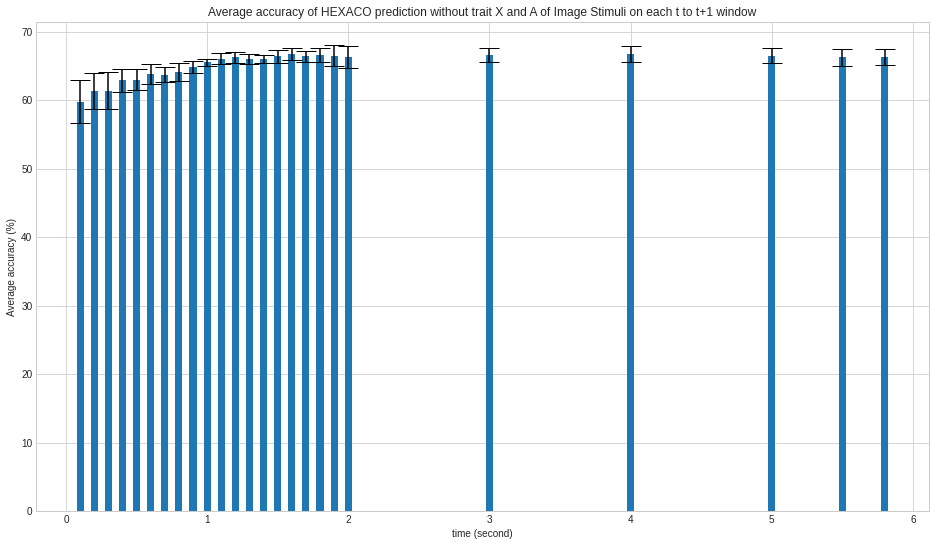

In [78]:
fig,ax = plt.subplots(figsize=(16,9))
ax.bar(times,np.mean(df_image,axis=1),[.05]*25,yerr=np.std(df_image,axis=1), ecolor='black', capsize=10)
# ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
# ax.errorbar([14,13,12,11,10,9,8,7,6,5,4,3,2,1,0],np.std(df,axis=1))
ax.set_title("Average accuracy of HEXACO prediction without trait X and A of Image Stimuli on each t to t+1 window")
ax.set_xlabel("time (second)")
ax.set_ylabel("Average accuracy (%)")
plt.show()

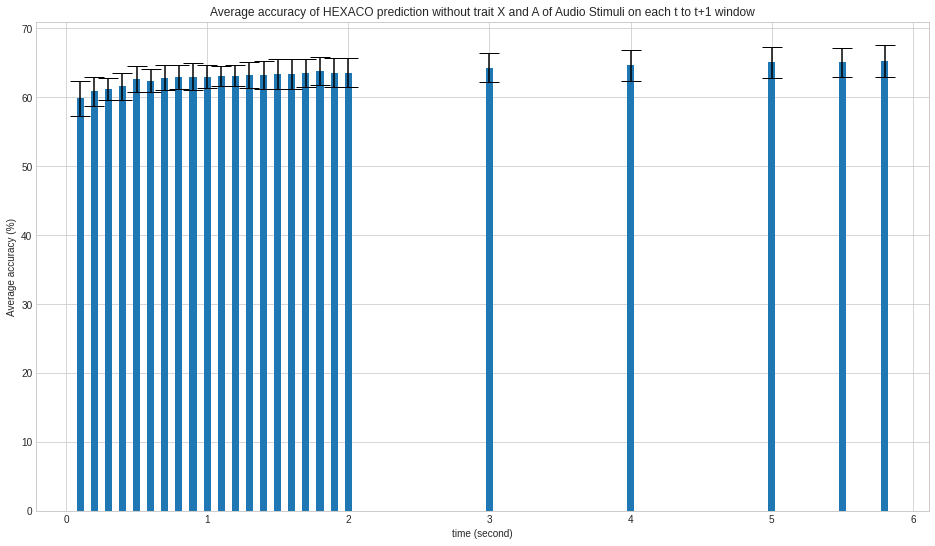

In [80]:
fig,ax = plt.subplots(figsize=(16,9))
ax.bar(times,np.mean(df_audio,axis=1),[.05]*25,yerr=np.std(df_audio,axis=1), ecolor='black', capsize=10)
# ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
# ax.errorbar([14,13,12,11,10,9,8,7,6,5,4,3,2,1,0],np.std(df,axis=1))
ax.set_title("Average accuracy of HEXACO prediction without trait X and A of Audio Stimuli on each t to t+1 window")
ax.set_xlabel("time (second)")
ax.set_ylabel("Average accuracy (%)")
plt.show()

# First 1 Second

In [10]:
with open(f'data_extract_raw/image_X.pickle', "rb") as handle:
    X = pickle.load(handle)
with open(f'data_extract_raw/image_data.pickle', "rb") as handle:
    data = pickle.load(handle)
Y = data['Y']


acc_time_image = dict()
score_time_image = dict()
for t in tqdm(times):
    print("="*20, t ,"="*20)
    for index,label in enumerate(['label_h','label_e','label_x','label_a','label_c','label_o']):
        # X_copy = X.copy()[:,:,:,int(sampleRate*t)-int(sampleRate*.5):int(sampleRate*t)]
        X_copy = X.copy()[:,:,:,:int(t)]
        # print(X_copy.shape)
        X_copy = np.mean(X_copy, axis=3)
        win = None
        for s in range(X_copy.shape[0]):
            row = np.expand_dims(X_copy[s].reshape(-1), axis=0)
            if(type(win) == type(None)): win = row
            else: win = np.concatenate([win,row], axis=0)
        win = win*-1
        y = Y[:,index]
        # print(win.shape, y.shape)
        clf = model()
        clf.fit(win, y)
        acc = sum(clf.predict(win) == y) / len(y)
        scores = cross_val_score(clf, win, y)
        # image_predictor[label] = clf
        print(label,"| Accuracy: %0.2f Scores: %0.2f (+/- %0.2f)" % (acc,scores.mean(), scores.std() * 2))
        if(label not in acc_time_image.keys()):
            acc_time_image[label] = list()
        if(label not in score_time_image.keys()):
            score_time_image[label] = list()
        acc_time_image[label].append(acc)
        score_time_image[label].append(scores.mean())


==================== 2 ====================
label_h | Accuracy: 0.55 Scores: 0.45 (+/- 0.05)
label_e | Accuracy: 0.60 Scores: 0.57 (+/- 0.06)
label_x | Accuracy: 0.77 Scores: 0.76 (+/- 0.01)
label_a | Accuracy: 0.74 Scores: 0.73 (+/- 0.02)
label_c | Accuracy: 0.63 Scores: 0.58 (+/- 0.07)
label_o | Accuracy: 0.55 Scores: 0.44 (+/- 0.08)
==================== 4 ====================
label_h | Accuracy: 0.56 Scores: 0.45 (+/- 0.05)
label_e | Accuracy: 0.59 Scores: 0.57 (+/- 0.06)
label_x | Accuracy: 0.77 Scores: 0.76 (+/- 0.01)
label_a | Accuracy: 0.74 Scores: 0.73 (+/- 0.02)
label_c | Accuracy: 0.63 Scores: 0.59 (+/- 0.07)
label_o | Accuracy: 0.55 Scores: 0.43 (+/- 0.08)
==================== 6 ====================
label_h | Accuracy: 0.55 Scores: 0.45 (+/- 0.06)
label_e | Accuracy: 0.59 Scores: 0.57 (+/- 0.06)
label_x | Accuracy: 0.77 Scores: 0.76 (+/- 0.01)
label_a | Accuracy: 0.74 Scores: 0.73 (+/- 0.01)
label_c | Accuracy: 0.63 Scores: 0.59 (+/- 0.07)
label_o | Accuracy: 0.55 Scores: 0.

In [15]:
df = pd.DataFrame()
df['time'] = times/250
for k in acc_time_image.keys():
    df[f"acc_{k}"] = acc_time_image[k]
# for k in score_time_image.keys():
#     df[f"sco_{k}"] = score_time_image[k]
df.set_index('time')
df.T.to_csv('data_extract_raw/audio_acc_1s.csv')

,acc_label_h,acc_label_e,acc_label_x,acc_label_a,acc_label_c,acc_label_o
time,,,,,,
0.008,0.554667,0.598667,0.766000,0.735333,0.628000,0.550667
0.016,0.556667,0.591333,0.766667,0.736000,0.626667,0.550000
0.024,0.550667,0.591333,0.766667,0.737333,0.629333,0.545333
0.032,0.557333,0.594667,0.766667,0.736667,0.628667,0.546667
0.040,0.556000,0.592667,0.766667,0.737333,0.629333,0.548667
...,...,...,...,...,...,...
0.968,0.644000,0.658667,0.766667,0.733333,0.650667,0.660667
0.976,0.645333,0.658667,0.766667,0.733333,0.650667,0.658667
0.984,0.646000,0.658000,0.766667,0.733333,0.651333,0.661333


In [17]:
df.T.to_csv('data_extract_raw/image_acc_1s.csv')

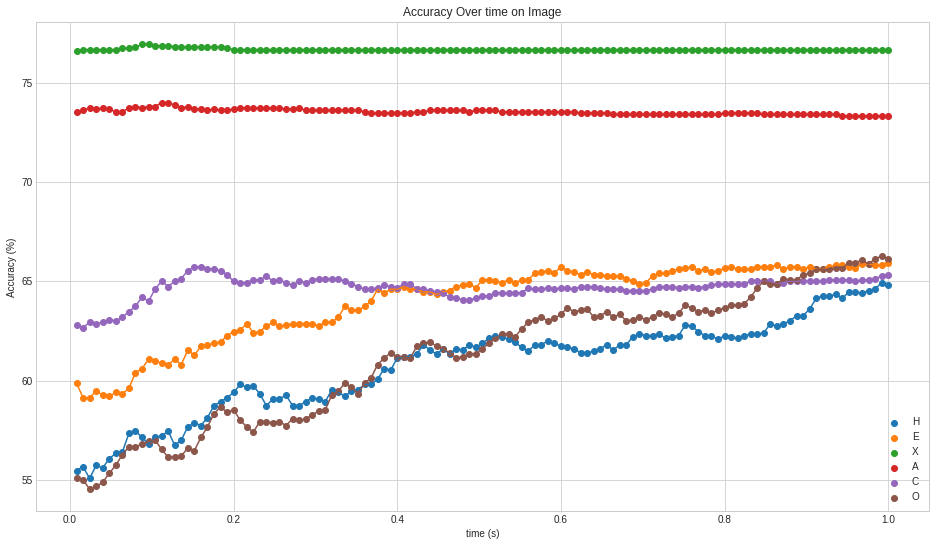

In [11]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(times/250,np.array(acc_time_image['label_h'])*100)
ax.plot(times/250,np.array(acc_time_image['label_e'])*100)
ax.plot(times/250,np.array(acc_time_image['label_x'])*100)
ax.plot(times/250,np.array(acc_time_image['label_a'])*100)
ax.plot(times/250,np.array(acc_time_image['label_c'])*100)
ax.plot(times/250,np.array(acc_time_image['label_o'])*100)

ax.scatter(times/250,np.array(acc_time_image['label_h'])*100, label='H')
ax.scatter(times/250,np.array(acc_time_image['label_e'])*100, label='E')
ax.scatter(times/250,np.array(acc_time_image['label_x'])*100, label='X')
ax.scatter(times/250,np.array(acc_time_image['label_a'])*100, label='A')
ax.scatter(times/250,np.array(acc_time_image['label_c'])*100, label='C')
ax.scatter(times/250,np.array(acc_time_image['label_o'])*100, label='O')

ax.legend()
ax.set_title('Accuracy Over time on Image')
ax.set_xlabel('time (s)')
ax.set_ylabel('Accuracy (%)')
plt.show()

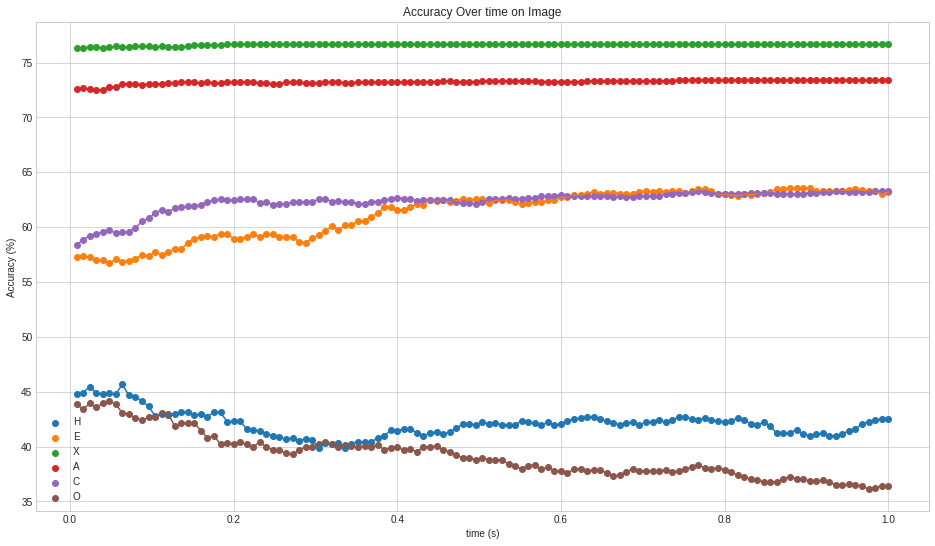

In [12]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(times/250,np.array(score_time_image['label_h'])*100)
ax.plot(times/250,np.array(score_time_image['label_e'])*100)
ax.plot(times/250,np.array(score_time_image['label_x'])*100)
ax.plot(times/250,np.array(score_time_image['label_a'])*100)
ax.plot(times/250,np.array(score_time_image['label_c'])*100)
ax.plot(times/250,np.array(score_time_image['label_o'])*100)

ax.scatter(times/250,np.array(score_time_image['label_h'])*100, label='H')
ax.scatter(times/250,np.array(score_time_image['label_e'])*100, label='E')
ax.scatter(times/250,np.array(score_time_image['label_x'])*100, label='X')
ax.scatter(times/250,np.array(score_time_image['label_a'])*100, label='A')
ax.scatter(times/250,np.array(score_time_image['label_c'])*100, label='C')
ax.scatter(times/250,np.array(score_time_image['label_o'])*100, label='O')

ax.legend()
ax.set_title('Accuracy Over time on Image')
ax.set_xlabel('time (s)')
ax.set_ylabel('Accuracy (%)')
plt.show()

In [25]:
with open(f'data_extract_raw/audio_X.pickle', "rb") as handle:
    X = pickle.load(handle)
with open(f'data_extract_raw/audio_data.pickle', "rb") as handle:
    data = pickle.load(handle)
Y = data['Y']


acc_time_audio = dict()
score_time_audio = dict()
for t in tqdm(times):
    print("="*20, t ,"="*20)
    for index,label in enumerate(['label_h','label_e','label_x','label_a','label_c','label_o']):
        # X_copy = X.copy()[:,:,:,int(sampleRate*t)-int(sampleRate*.5):int(sampleRate*t)]
        X_copy = X.copy()[:,:,:,:int(t*sampleRate)]
        # print(X_copy.shape)
        X_copy = np.mean(X_copy, axis=3)
        win = None
        for s in range(X_copy.shape[0]):
            row = np.expand_dims(X_copy[s].reshape(-1), axis=0)
            if(type(win) == type(None)): win = row
            else: win = np.concatenate([win,row], axis=0)
        win = win*-1
        y = Y[:,index]
        # print(win.shape, y.shape)
        clf = model()
        clf.fit(win, y)
        acc = sum(clf.predict(win) == y) / len(y)
        scores = cross_val_score(clf, win, y)
        # audio_predictor[label] = clf
        print(label,"| Accuracy: %0.2f Scores: %0.2f (+/- %0.2f)" % (acc,scores.mean(), scores.std() * 2))
        if(label not in acc_time_audio.keys()):
            acc_time_audio[label] = list()
        if(label not in score_time_audio.keys()):
            score_time_audio[label] = list()
        acc_time_audio[label].append(acc)
        score_time_audio[label].append(scores.mean())


==================== 0.1 ====================
label_h | Accuracy: 0.56 Scores: 0.40 (+/- 0.13)
label_e | Accuracy: 0.61 Scores: 0.57 (+/- 0.03)
label_x | Accuracy: 0.76 Scores: 0.76 (+/- 0.02)
label_a | Accuracy: 0.73 Scores: 0.72 (+/- 0.02)
label_c | Accuracy: 0.63 Scores: 0.58 (+/- 0.07)
label_o | Accuracy: 0.58 Scores: 0.49 (+/- 0.05)
==================== 0.2 ====================
label_h | Accuracy: 0.58 Scores: 0.42 (+/- 0.12)
label_e | Accuracy: 0.63 Scores: 0.57 (+/- 0.06)
label_x | Accuracy: 0.76 Scores: 0.76 (+/- 0.02)
label_a | Accuracy: 0.73 Scores: 0.71 (+/- 0.05)
label_c | Accuracy: 0.63 Scores: 0.60 (+/- 0.04)
label_o | Accuracy: 0.59 Scores: 0.50 (+/- 0.08)
==================== 0.3 ====================
label_h | Accuracy: 0.59 Scores: 0.42 (+/- 0.15)
label_e | Accuracy: 0.62 Scores: 0.57 (+/- 0.05)
label_x | Accuracy: 0.77 Scores: 0.76 (+/- 0.02)
label_a | Accuracy: 0.74 Scores: 0.71 (+/- 0.04)
label_c | Accuracy: 0.63 Scores: 0.61 (+/- 0.07)
label_o | Accuracy: 0.60 Scor

In [27]:
df = pd.DataFrame()
df['time'] = times
for k in acc_time_image.keys():
    df[f"acc_{k}"] = acc_time_audio[k]
# for k in score_time_image.keys():
#     df[f"sco_{k}"] = score_time_audio[k]
df.set_index('time')
df.T.to_csv('data_extract_raw/audio_acc_1s.csv')
df.T

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
time,0.100000,0.200000,0.300000,0.400000,0.500000,0.600000,0.700000,0.800000,0.900000,1.000000,...,1.600000,1.700000,1.800000,1.900000,2.000000,3.000000,4.000000,5.000000,5.500000,5.800000
acc_label_h,0.564667,0.582667,0.590667,0.590000,0.605333,0.606667,0.610000,0.616000,0.618667,0.622000,...,0.621333,0.628667,0.632000,0.624667,0.626667,0.646667,0.644667,0.650000,0.655333,0.660000
acc_label_e,0.614667,0.628667,0.621333,0.616667,0.614000,0.614667,0.614000,0.614667,0.615333,0.614000,...,0.608000,0.607333,0.608000,0.608000,0.606667,0.608000,0.610667,0.614000,0.614667,0.614000
acc_label_x,0.764667,0.763333,0.766000,0.765333,0.766000,0.766667,0.770000,0.768667,0.769333,0.769333,...,0.768667,0.766667,0.766667,0.766667,0.767333,0.764667,0.765333,0.765333,0.764667,0.764667
acc_label_a,0.732000,0.730000,0.735333,0.735333,0.735333,0.734667,0.736000,0.735333,0.734667,0.734667,...,0.734000,0.734000,0.734000,0.734000,0.734000,0.734000,0.733333,0.733333,0.733333,0.733333
acc_label_c,0.630000,0.628667,0.632667,0.645333,0.653333,0.652000,0.656000,0.657333,0.664667,0.658000,...,0.666000,0.664000,0.662000,0.660000,0.658000,0.660000,0.668000,0.667333,0.664667,0.668000
acc_label_o,0.584667,0.594667,0.603333,0.613333,0.633333,0.624667,0.634667,0.630000,0.622000,0.626000,...,0.640667,0.642667,0.650000,0.652000,0.652667,0.657333,0.663333,0.672000,0.668667,0.669333


No handles with labels found to put in legend.


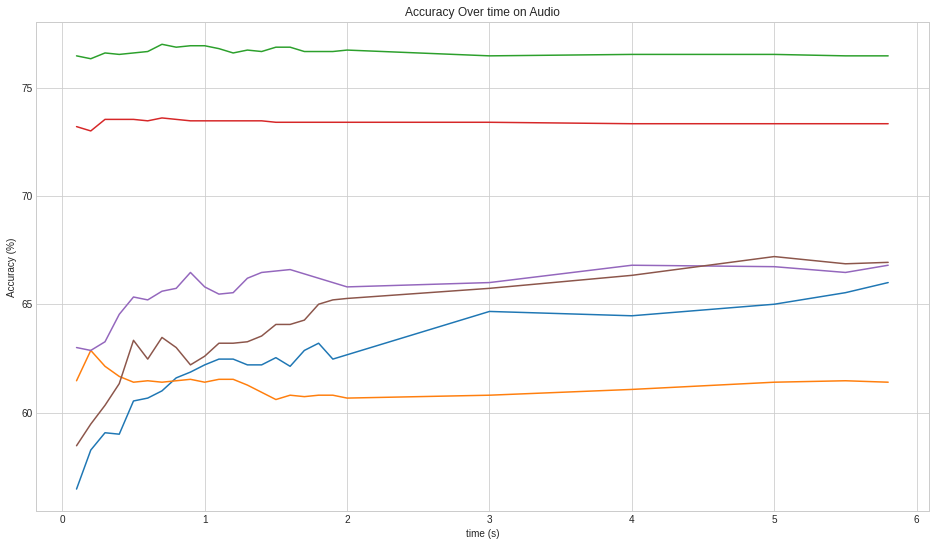

In [29]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(times,np.array(acc_time_audio['label_h'])*100)
ax.plot(times,np.array(acc_time_audio['label_e'])*100)
ax.plot(times,np.array(acc_time_audio['label_x'])*100)
ax.plot(times,np.array(acc_time_audio['label_a'])*100)
ax.plot(times,np.array(acc_time_audio['label_c'])*100)
ax.plot(times,np.array(acc_time_audio['label_o'])*100)

# ax.scatter(times/250,np.array(acc_time_audio['label_h'])*100, label='H')
# ax.scatter(times/250,np.array(acc_time_audio['label_e'])*100, label='E')
# ax.scatter(times/250,np.array(acc_time_audio['label_x'])*100, label='X')
# ax.scatter(times/250,np.array(acc_time_audio['label_a'])*100, label='A')
# ax.scatter(times/250,np.array(acc_time_audio['label_c'])*100, label='C')
# ax.scatter(times/250,np.array(acc_time_audio['label_o'])*100, label='O')

ax.legend()
ax.set_title('Accuracy Over time on Audio')
ax.set_xlabel('time (s)')
ax.set_ylabel('Accuracy (%)')
plt.show()

# ASDASD

In [11]:
with open(f'data_extract_raw/image_X.pickle', "rb") as handle:
    X = pickle.load(handle)
with open(f'data_extract_raw/image_data.pickle', "rb") as handle:
    data = pickle.load(handle)
Y = data['Y']


acc_time_image = dict()
score_time_image = dict()
for t in times:
    print("="*20, t ,"="*20)
    for index,label in enumerate(['label_h','label_e','label_x','label_a','label_c','label_o']):
        # X_copy = X.copy()[:,:,:,int(sampleRate*t)-int(sampleRate*.5):int(sampleRate*t)]
        X_copy = X.copy()[:,:,:,:int(sampleRate*t)]
        # print(X_copy.shape)
        X_copy = np.mean(X_copy, axis=3)
        win = None
        for s in range(X_copy.shape[0]):
            row = np.expand_dims(X_copy[s].reshape(-1), axis=0)
            if(type(win) == type(None)): win = row
            else: win = np.concatenate([win,row], axis=0)
        win = win*-1
        y = Y[:,index]
        # print(win.shape, y.shape)
        clf = model()
        clf.fit(win, y)
        acc = sum(clf.predict(win) == y) / len(y)
        scores = cross_val_score(clf, win, y)
        # image_predictor[label] = clf
        print(label,"| Accuracy: %0.2f Scores: %0.2f (+/- %0.2f)" % (acc,scores.mean(), scores.std() * 2))
        if(label not in acc_time_image.keys()):
            acc_time_image[label] = list()
        if(label not in score_time_image.keys()):
            score_time_image[label] = list()
        acc_time_image[label].append(acc)
        score_time_image[label].append(scores.mean())

==================== 0.1 ====================
label_h | Accuracy: 0.57 Scores: 0.43 (+/- 0.11)
label_e | Accuracy: 0.61 Scores: 0.57 (+/- 0.03)
label_x | Accuracy: 0.77 Scores: 0.76 (+/- 0.01)
label_a | Accuracy: 0.74 Scores: 0.73 (+/- 0.01)
label_c | Accuracy: 0.64 Scores: 0.61 (+/- 0.06)
label_o | Accuracy: 0.57 Scores: 0.43 (+/- 0.07)
==================== 0.2 ====================
label_h | Accuracy: 0.59 Scores: 0.42 (+/- 0.14)
label_e | Accuracy: 0.62 Scores: 0.59 (+/- 0.03)
label_x | Accuracy: 0.77 Scores: 0.77 (+/- 0.00)
label_a | Accuracy: 0.74 Scores: 0.73 (+/- 0.01)
label_c | Accuracy: 0.65 Scores: 0.62 (+/- 0.07)
label_o | Accuracy: 0.59 Scores: 0.40 (+/- 0.11)
==================== 0.3 ====================
label_h | Accuracy: 0.59 Scores: 0.40 (+/- 0.12)
label_e | Accuracy: 0.63 Scores: 0.59 (+/- 0.05)
label_x | Accuracy: 0.77 Scores: 0.77 (+/- 0.00)
label_a | Accuracy: 0.74 Scores: 0.73 (+/- 0.00)
label_c | Accuracy: 0.65 Scores: 0.62 (+/- 0.08)
label_o | Accuracy: 0.58 Scor

In [26]:
df = pd.DataFrame()
df['time'] = times
for k in acc_time_image.keys():
    df[f"acc_{k}"] = acc_time_image[k]
for k in score_time_image.keys():
    df[f"sco_{k}"] = score_time_image[k]
df.set_index('time')

,acc_label_h,acc_label_e,acc_label_x,acc_label_a,acc_label_c,acc_label_o,sco_label_h,sco_label_e,sco_label_x,sco_label_a,sco_label_c,sco_label_o
time,,,,,,,,,,,,
0.1,0.567333,0.611333,0.769333,0.738000,0.644000,0.570000,0.434000,0.574000,0.764000,0.731333,0.612667,0.427333
0.2,0.594000,0.624667,0.766667,0.736667,0.650000,0.585333,0.423333,0.589333,0.766667,0.732000,0.624667,0.402667
0.3,0.593333,0.628667,0.766667,0.736000,0.650667,0.584000,0.402000,0.592000,0.766667,0.731333,0.624000,0.401333
0.4,0.611333,0.646000,0.766667,0.734667,0.646667,0.612000,0.414667,0.616000,0.766667,0.732000,0.626667,0.400000
0.5,0.617333,0.648000,0.766667,0.736000,0.642000,0.614000,0.422667,0.626000,0.766667,0.732667,0.622667,0.390000
0.6,0.617333,0.657333,0.766667,0.735333,0.646667,0.633333,0.420667,0.627333,0.766667,0.732667,0.629333,0.378000
0.7,0.622000,0.650000,0.766667,0.734000,0.644667,0.633333,0.421333,0.632000,0.766667,0.733333,0.628000,0.379333
0.8,0.622667,0.656667,0.766667,0.734667,0.648667,0.636667,0.422000,0.630000,0.766667,0.734000,0.630667,0.378667
0.9,0.634667,0.657333,0.766667,0.734000,0.650000,0.653333,0.409333,0.636000,0.766667,0.734000,0.631333,0.370000


In [32]:
df.T.to_csv('data_extract_raw/image_acc_score.csv')

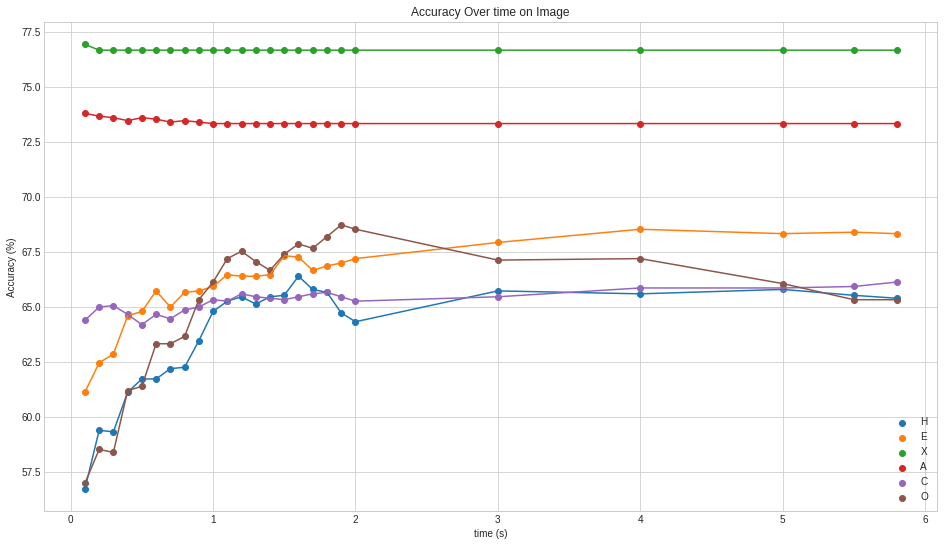

In [33]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

fig, ax = plt.subplots(figsize=(16,9))
ax.plot(times,np.array(acc_time_image['label_h'])*100)
ax.plot(times,np.array(acc_time_image['label_e'])*100)
ax.plot(times,np.array(acc_time_image['label_x'])*100)
ax.plot(times,np.array(acc_time_image['label_a'])*100)
ax.plot(times,np.array(acc_time_image['label_c'])*100)
ax.plot(times,np.array(acc_time_image['label_o'])*100)

ax.scatter(times,np.array(acc_time_image['label_h'])*100, label='H')
ax.scatter(times,np.array(acc_time_image['label_e'])*100, label='E')
ax.scatter(times,np.array(acc_time_image['label_x'])*100, label='X')
ax.scatter(times,np.array(acc_time_image['label_a'])*100, label='A')
ax.scatter(times,np.array(acc_time_image['label_c'])*100, label='C')
ax.scatter(times,np.array(acc_time_image['label_o'])*100, label='O')

ax.legend()
ax.set_title('Accuracy Over time on Image')
ax.set_xlabel('time (s)')
ax.set_ylabel('Accuracy (%)')
plt.show()

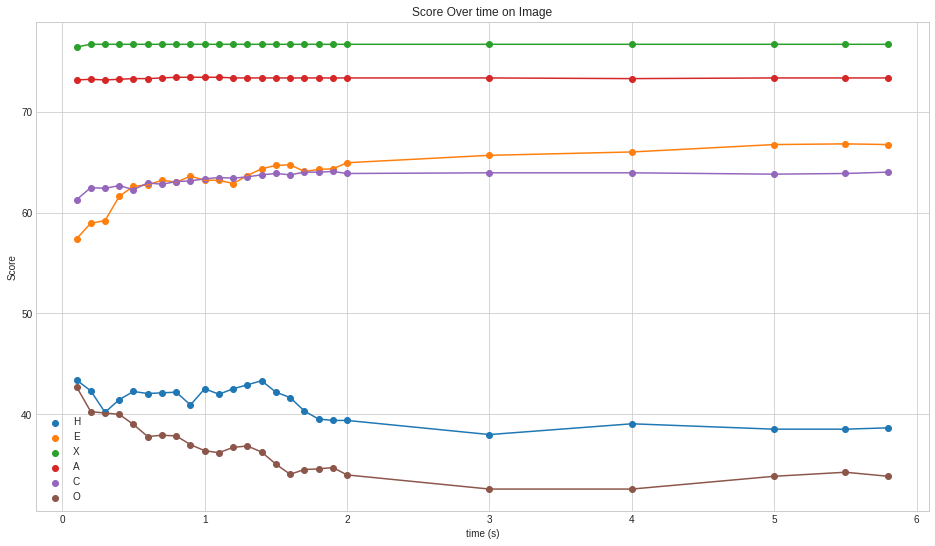

In [34]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(times,np.array(score_time_image['label_h'])*100)
ax.plot(times,np.array(score_time_image['label_e'])*100)
ax.plot(times,np.array(score_time_image['label_x'])*100)
ax.plot(times,np.array(score_time_image['label_a'])*100)
ax.plot(times,np.array(score_time_image['label_c'])*100)
ax.plot(times,np.array(score_time_image['label_o'])*100)

ax.scatter(times,np.array(score_time_image['label_h'])*100, label='H')
ax.scatter(times,np.array(score_time_image['label_e'])*100, label='E')
ax.scatter(times,np.array(score_time_image['label_x'])*100, label='X')
ax.scatter(times,np.array(score_time_image['label_a'])*100, label='A')
ax.scatter(times,np.array(score_time_image['label_c'])*100, label='C')
ax.scatter(times,np.array(score_time_image['label_o'])*100, label='O')

ax.legend()
ax.set_title('Score Over time on Image')
ax.set_xlabel('time (s)')
ax.set_ylabel('Score')
plt.show()

In [20]:
with open(f'data_extract_raw/audio_X.pickle', "rb") as handle:
    X = pickle.load(handle)
with open(f'data_extract_raw/audio_data.pickle', "rb") as handle:
    data = pickle.load(handle)
Y = data['Y']
acc_time_audio = dict()
score_time_audio = dict()
for t in times:
    print("="*20, t ,"="*20)
    for index,label in enumerate(['label_h','label_e','label_x','label_a','label_c','label_o']):
        X_copy = X.copy()[:,:,:,:int(sampleRate*t)]
        # print(X_copy.shape)
        X_copy = np.mean(X_copy, axis=3)
        win = None
        for s in range(X_copy.shape[0]):
            row = np.expand_dims(X_copy[s].reshape(-1), axis=0)
            if(type(win) == type(None)): win = row
            else: win = np.concatenate([win,row], axis=0)
        win = win*-1
        y = Y[:,index]
        # print(win.shape, y.shape)
        clf = model()
        clf.fit(win, y)
        acc = sum(clf.predict(win) == y) / len(y)
        scores = cross_val_score(clf, win, y)
        # image_predictor[label] = clf
        print(label,"| Accuracy: %0.2f Scores: %0.2f (+/- %0.2f)" % (acc,scores.mean(), scores.std() * 2))
        if(label not in acc_time_audio.keys()):
            acc_time_audio[label] = list()
        acc_time_audio[label].append(acc)
        if(label not in score_time_audio.keys()):
            score_time_audio[label] = list()
        score_time_audio[label].append(scores.mean())


==================== 2 ====================
label_h | Accuracy: 0.63 Scores: 0.40 (+/- 0.24)
label_e | Accuracy: 0.61 Scores: 0.59 (+/- 0.02)
label_x | Accuracy: 0.77 Scores: 0.76 (+/- 0.01)
label_a | Accuracy: 0.73 Scores: 0.72 (+/- 0.03)
label_c | Accuracy: 0.66 Scores: 0.62 (+/- 0.06)
label_o | Accuracy: 0.65 Scores: 0.54 (+/- 0.14)
==================== 4 ====================
label_h | Accuracy: 0.64 Scores: 0.41 (+/- 0.20)
label_e | Accuracy: 0.61 Scores: 0.59 (+/- 0.04)
label_x | Accuracy: 0.77 Scores: 0.76 (+/- 0.01)
label_a | Accuracy: 0.73 Scores: 0.72 (+/- 0.03)
label_c | Accuracy: 0.67 Scores: 0.63 (+/- 0.06)
label_o | Accuracy: 0.66 Scores: 0.57 (+/- 0.11)
==================== 6 ====================
label_h | Accuracy: 0.66 Scores: 0.41 (+/- 0.19)
label_e | Accuracy: 0.61 Scores: 0.59 (+/- 0.04)
label_x | Accuracy: 0.76 Scores: 0.76 (+/- 0.02)
label_a | Accuracy: 0.73 Scores: 0.72 (+/- 0.03)
label_c | Accuracy: 0.67 Scores: 0.64 (+/- 0.07)
label_o | Accuracy: 0.67 Scores: 0.

KeyboardInterrupt: 

In [30]:
df = pd.DataFrame()
df['time'] = times
for k in acc_time_audio.keys():
    df[f"acc_{k}"] = acc_time_audio[k]
for k in score_time_audio.keys():
    df[f"sco_{k}"] = score_time_audio[k]
df.set_index('time')

,acc_label_h,acc_label_e,acc_label_x,acc_label_a,acc_label_c,acc_label_o,sco_label_h,sco_label_e,sco_label_x,sco_label_a,sco_label_c,sco_label_o
time,,,,,,,,,,,,
0.1,0.564667,0.614667,0.764667,0.732000,0.630000,0.584667,0.396000,0.572667,0.761333,0.720000,0.582667,0.489333
0.2,0.582667,0.628667,0.763333,0.730000,0.628667,0.594667,0.420000,0.573333,0.756000,0.712000,0.602667,0.503333
0.3,0.590667,0.621333,0.766000,0.735333,0.632667,0.603333,0.418667,0.572667,0.756667,0.712667,0.610000,0.521333
0.4,0.590000,0.616667,0.765333,0.735333,0.645333,0.613333,0.414000,0.575333,0.757333,0.712667,0.612000,0.530000
0.5,0.605333,0.614000,0.766000,0.735333,0.653333,0.633333,0.420000,0.579333,0.758000,0.714000,0.614667,0.532000
0.6,0.606667,0.614667,0.766667,0.734667,0.652000,0.624667,0.424667,0.584000,0.757333,0.718000,0.622667,0.531333
0.7,0.610000,0.614000,0.770000,0.736000,0.656000,0.634667,0.418667,0.576667,0.758000,0.720667,0.624000,0.532667
0.8,0.616000,0.614667,0.768667,0.735333,0.657333,0.630000,0.417333,0.577333,0.758667,0.718667,0.623333,0.518667
0.9,0.618667,0.615333,0.769333,0.734667,0.664667,0.622000,0.406000,0.578000,0.758667,0.718000,0.616000,0.520667


In [33]:
df.T.to_csv('data_extract_raw/audio_acc_score.csv')

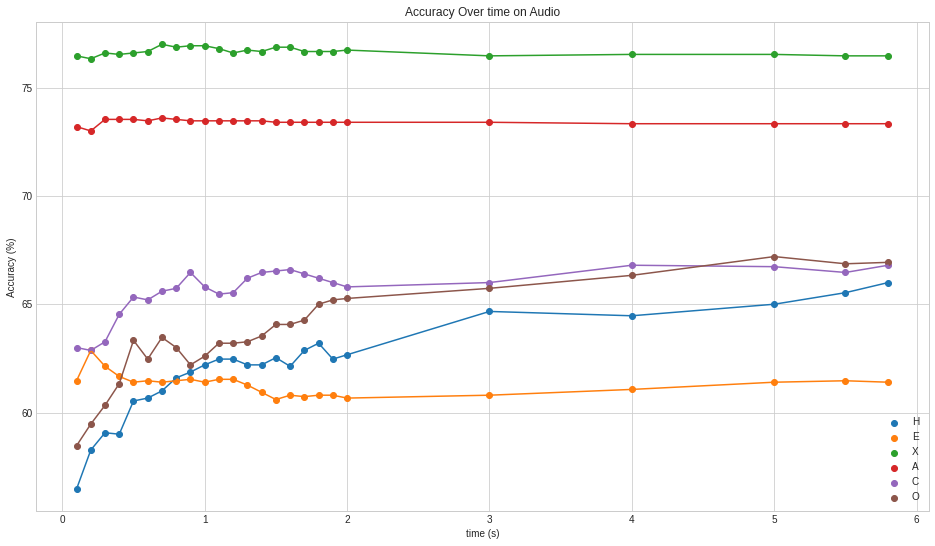

In [19]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(times,np.array(acc_time_audio['label_h'])*100)
ax.plot(times,np.array(acc_time_audio['label_e'])*100)
ax.plot(times,np.array(acc_time_audio['label_x'])*100)
ax.plot(times,np.array(acc_time_audio['label_a'])*100)
ax.plot(times,np.array(acc_time_audio['label_c'])*100)
ax.plot(times,np.array(acc_time_audio['label_o'])*100)

ax.scatter(times,np.array(acc_time_audio['label_h'])*100, label='H')
ax.scatter(times,np.array(acc_time_audio['label_e'])*100, label='E')
ax.scatter(times,np.array(acc_time_audio['label_x'])*100, label='X')
ax.scatter(times,np.array(acc_time_audio['label_a'])*100, label='A')
ax.scatter(times,np.array(acc_time_audio['label_c'])*100, label='C')
ax.scatter(times,np.array(acc_time_audio['label_o'])*100, label='O')

ax.legend()
ax.set_title('Accuracy Over time on Audio')
ax.set_xlabel('time (s)')
ax.set_ylabel('Accuracy (%)')
plt.show()

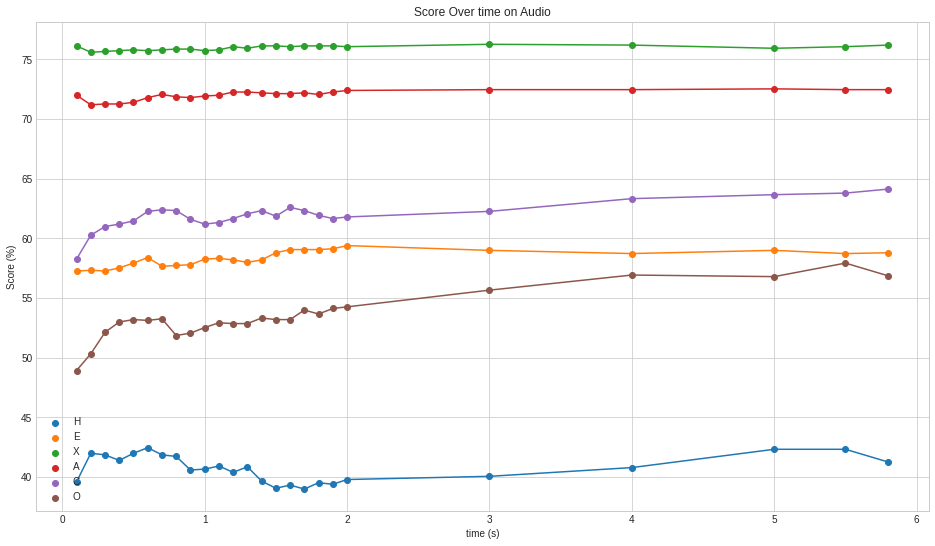

In [20]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(times,np.array(score_time_audio['label_h'])*100)
ax.plot(times,np.array(score_time_audio['label_e'])*100)
ax.plot(times,np.array(score_time_audio['label_x'])*100)
ax.plot(times,np.array(score_time_audio['label_a'])*100)
ax.plot(times,np.array(score_time_audio['label_c'])*100)
ax.plot(times,np.array(score_time_audio['label_o'])*100)

ax.scatter(times,np.array(score_time_audio['label_h'])*100, label='H')
ax.scatter(times,np.array(score_time_audio['label_e'])*100, label='E')
ax.scatter(times,np.array(score_time_audio['label_x'])*100, label='X')
ax.scatter(times,np.array(score_time_audio['label_a'])*100, label='A')
ax.scatter(times,np.array(score_time_audio['label_c'])*100, label='C')
ax.scatter(times,np.array(score_time_audio['label_o'])*100, label='O')

ax.legend()
ax.set_title('Score Over time on Audio')
ax.set_xlabel('time (s)')
ax.set_ylabel('Score (%)')
plt.show()

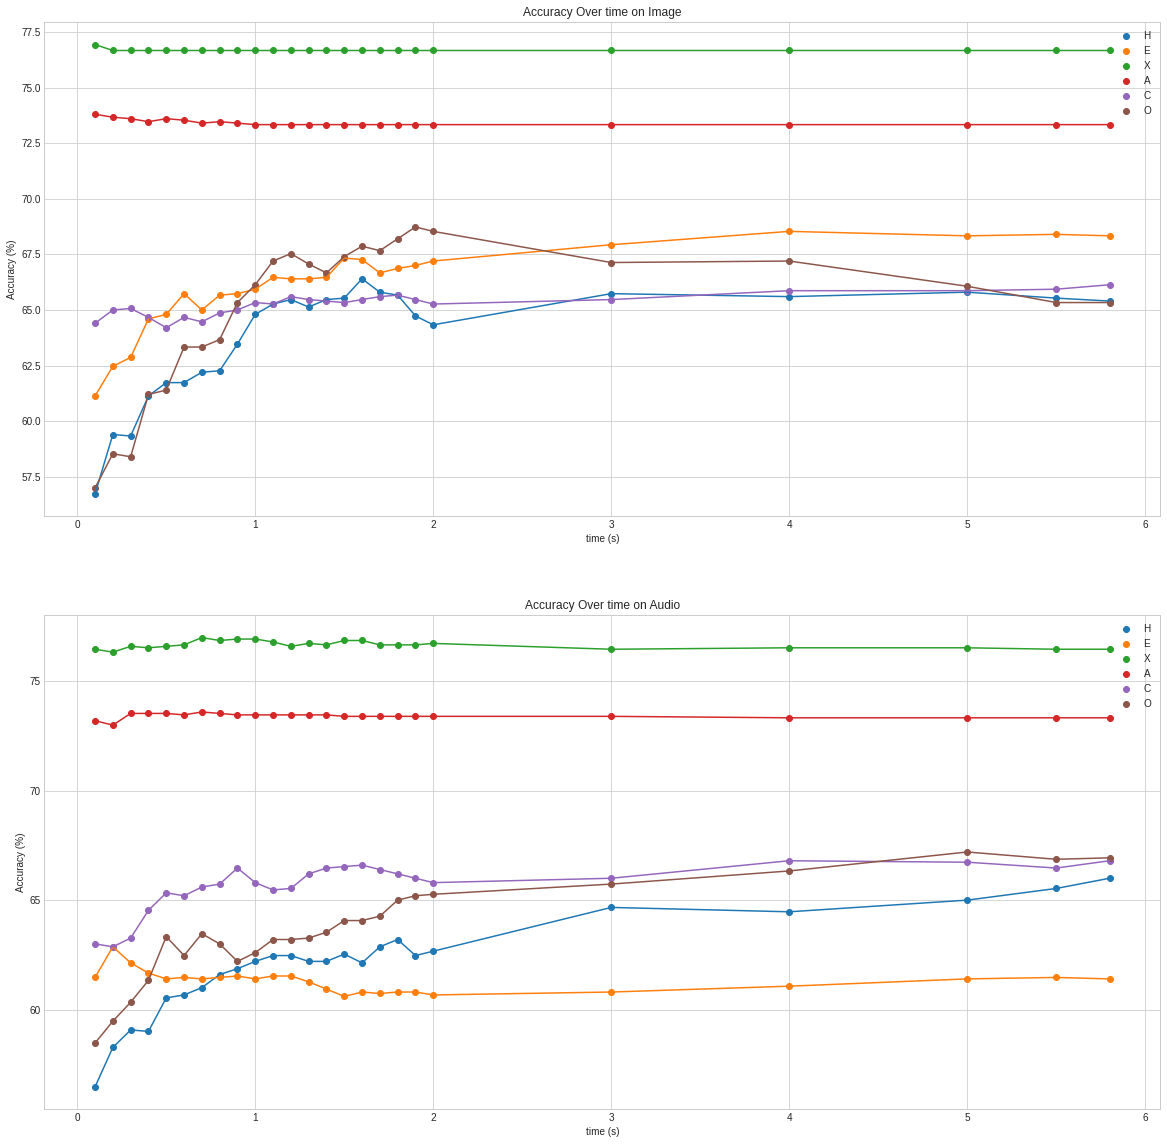

In [21]:
fig, ax = plt.subplots(2,figsize=(20,20))

ax[0].plot(times,np.array(acc_time_image['label_h'])*100)
ax[0].plot(times,np.array(acc_time_image['label_e'])*100)
ax[0].plot(times,np.array(acc_time_image['label_x'])*100)
ax[0].plot(times,np.array(acc_time_image['label_a'])*100)
ax[0].plot(times,np.array(acc_time_image['label_c'])*100)
ax[0].plot(times,np.array(acc_time_image['label_o'])*100)

ax[0].scatter(times,np.array(acc_time_image['label_h'])*100, label='H')
ax[0].scatter(times,np.array(acc_time_image['label_e'])*100, label='E')
ax[0].scatter(times,np.array(acc_time_image['label_x'])*100, label='X')
ax[0].scatter(times,np.array(acc_time_image['label_a'])*100, label='A')
ax[0].scatter(times,np.array(acc_time_image['label_c'])*100, label='C')
ax[0].scatter(times,np.array(acc_time_image['label_o'])*100, label='O')

ax[0].legend()
ax[0].set_title('Accuracy Over time on Image')
ax[0].set_xlabel('time (s)')
ax[0].set_ylabel('Accuracy (%)')


ax[1].plot(times,np.array(acc_time_audio['label_h'])*100)
ax[1].plot(times,np.array(acc_time_audio['label_e'])*100)
ax[1].plot(times,np.array(acc_time_audio['label_x'])*100)
ax[1].plot(times,np.array(acc_time_audio['label_a'])*100)
ax[1].plot(times,np.array(acc_time_audio['label_c'])*100)
ax[1].plot(times,np.array(acc_time_audio['label_o'])*100)

ax[1].scatter(times,np.array(acc_time_audio['label_h'])*100, label='H')
ax[1].scatter(times,np.array(acc_time_audio['label_e'])*100, label='E')
ax[1].scatter(times,np.array(acc_time_audio['label_x'])*100, label='X')
ax[1].scatter(times,np.array(acc_time_audio['label_a'])*100, label='A')
ax[1].scatter(times,np.array(acc_time_audio['label_c'])*100, label='C')
ax[1].scatter(times,np.array(acc_time_audio['label_o'])*100, label='O')

ax[1].legend()
ax[1].set_title('Accuracy Over time on Audio')
ax[1].set_xlabel('time (s)')
ax[1].set_ylabel('Accuracy (%)')
plt.show()

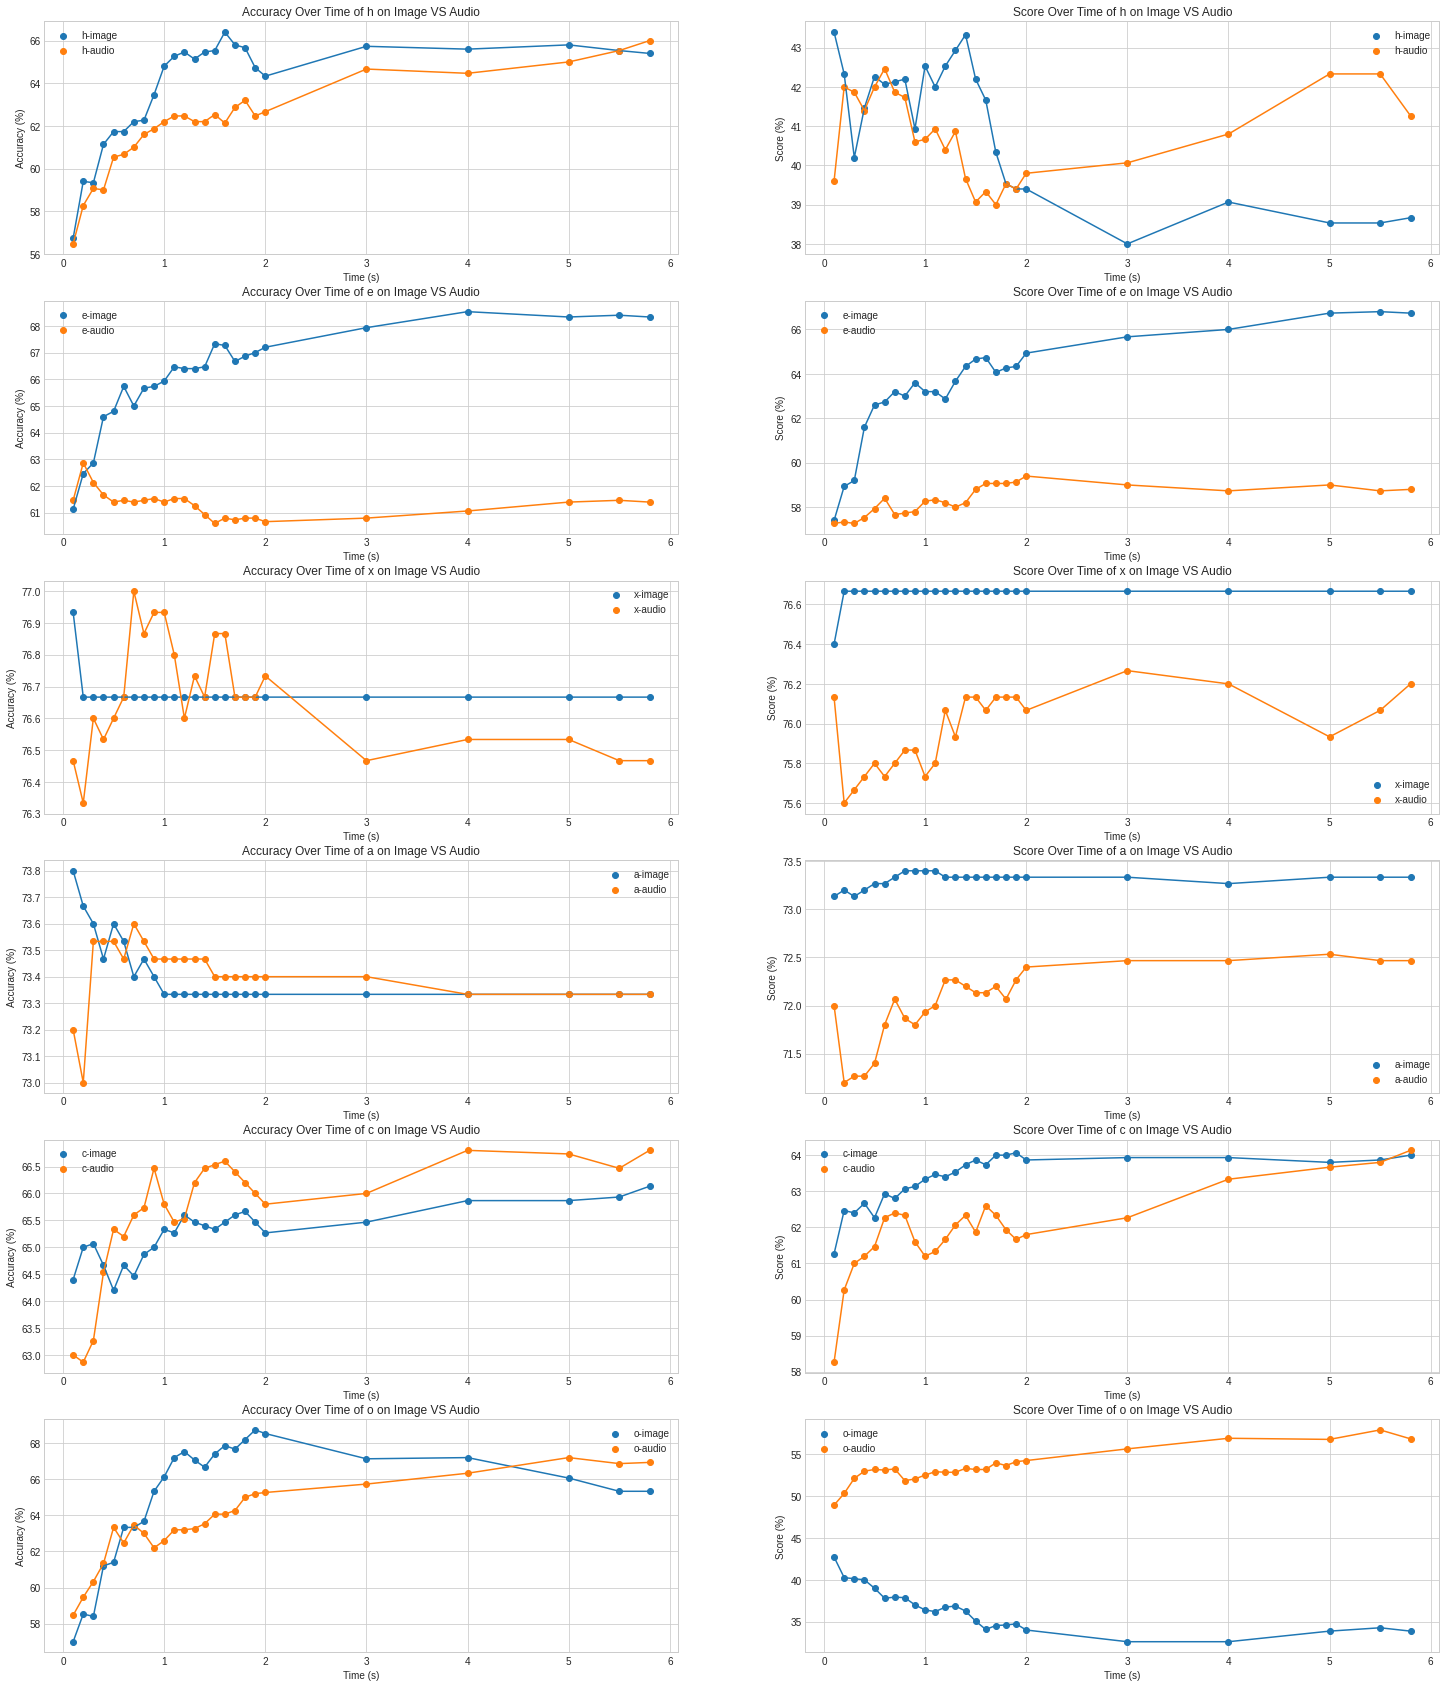

In [46]:
fig,ax = plt.subplots(nrows=6,ncols=2,figsize=(25,30))
labels = ['label_h','label_e','label_x','label_a','label_c','label_o']

for index, label in enumerate(labels):
    ax[index][0].plot(times,np.array(acc_time_image[label])*100)
    ax[index][0].scatter(times,np.array(acc_time_image[label])*100,label=f"{label.split('_')[1]}-image")
    ax[index][0].plot(times,np.array(acc_time_audio[label])*100)
    ax[index][0].scatter(times,np.array(acc_time_audio[label])*100,label=f"{label.split('_')[1]}-audio")
    ax[index][0].legend()
    ax[index][0].set_title(f"Accuracy Over Time of {label.split('_')[1]} on Image VS Audio")
    ax[index][0].set_xlabel('Time (s)')
    ax[index][0].set_ylabel('Accuracy (%)')

for index, label in enumerate(labels):
    ax[index][1].plot(times,np.array(score_time_image[label])*100)
    ax[index][1].scatter(times,np.array(score_time_image[label])*100,label=f"{label.split('_')[1]}-image")
    ax[index][1].plot(times,np.array(score_time_audio[label])*100)
    ax[index][1].scatter(times,np.array(score_time_audio[label])*100,label=f"{label.split('_')[1]}-audio")
    ax[index][1].legend()
    ax[index][1].set_title(f"Score Over Time of {label.split('_')[1]} on Image VS Audio")
    ax[index][1].set_xlabel('Time (s)')
    ax[index][1].set_ylabel('Score (%)')

plt.show()

